# VAE Variational Autoencoder

import needest modules

In [14]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import torch
import torch.nn as nn
from torch import optim 
from torchinfo import summary
from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable 

from tqdm import tqdm
import matplotlib.pyplot as plt

from model import VAE
from data import Ego4d, DEVICE, BATCH_SIZE, transform1, transform2, ResumableRandomSampler

from ray.train import ScalingConfig
from ray.train.torch import TorchTrainer
import ray

device cuda is ready


prepare dataset for training

In [3]:
scaling_config = ScalingConfig(num_workers=1, use_gpu=True)

In [4]:
checkpoint = torch.load('/home/qwest/project/PycharmProjects/Reinforsment_Learning/VAE/weights/weights/main/VAE_checkpoint_32_175.pt')

/tmp/ipykernel_711040/1764761763.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/home/qwest/project/PycharmProjects/Reinforsment_Learning/VAE/w

ModuleNotFoundError: No module named 'VAE'

In [18]:
torch.cuda.is_available()

True

In [19]:
print('transform initializate sucsess')
train_dataset = Ego4d(img_dir='/mnt/750G/data/droid_all',
                           transform1=transform1,
                           transform2=transform2)
print("train_dataset init")
sampler = ResumableRandomSampler(train_dataset)
#sampler.set_state(checkpoint['sampler_state'])
print("train_sampler init")
train_loader = DataLoader(dataset=train_dataset,
                           batch_size=32,
                           shuffle=False,
                           sampler=sampler,)
print("train_loader init")

transform initializate sucsess
train_dataset init
train_sampler init
train_loader init


In [20]:
print("Len of trainloader: ",len(train_loader))


Len of trainloader:  690


setup param's for VAE training

In [21]:
lr = 0.001
epochs = 200
latent_dim = 32

create model & optimizer with parametrs ^^^ 

In [22]:
model = VAE(latent_dim, batch_size=BATCH_SIZE)
optimizer = optim.Adam(model.parameters(), lr=lr)

## OR

In [23]:
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

create train func 

In [24]:
import matplotlib.pyplot as p

train model with logging on mlflow 

In [25]:
def ray_train():
    train_loader = ray.train.torch.prepare_data_loader(train_loader)
    model = ray.train.torch.prepare_model(model)
    """
        train VAE model.

        Args:
        epoch (int): number of epoch.
    """
    for epoch in range(epoch, epochs+1):
        x = next(iter(train_loader))
        model.train()
        print(f'Epoch {epoch} start')
        eval_loss = 0
        # Loop through all batches in the training dataset
        for i, data, in enumerate(tqdm(train_loader)):
#                data = data.to(DEVICE)
                optimizer.zero_grad()
                
                recon_batch, mu, logvar = model(data)
                loss = model.loss_function(recon_batch, data, mu, logvar)
                eval_loss += loss
                
                loss.backward() # Compute the gradients with respect to the model parameters
                
                optimizer.step() # Update the model parameters using the optimizer

        torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss':loss,
                        'epoch':epoch,
                        'full_model':model,
                        'sampler_state':sampler.get_state(),
                        },
                        f'weights/main/VAE_checkpoint_robot_{latent_dim}_{epoch}.pt')
        
        print(f"Avg loss: {loss:2f} \n")
        model.eval()
        recon_img, _, _ = model(x[:1])#.to(DEVICE))
        img = recon_img.view(3, 64, 64).detach().cpu().numpy().transpose(1, 2, 0)
        f = p.imshow(img)
        p.show()

In [26]:
# [4] Configure scaling and resource requirements.


# [5] Launch distributed training job.
trainer = ray.train.torch.TorchTrainer(
    ray_train,
    scaling_config=scaling_config,
    # [5a] If running in a multi-node cluster, this is where you
    # should configure the run's persistent storage that is accessible
    # across all worker nodes.
    # run_config=ray.train.RunConfig(storage_path="s3://..."),
)
result = trainer.fit()

2024-12-14 21:01:12,248	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2024-12-14 21:01:12 (running for 00:00:00.11)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:CMP)
Result logdir: /tmp/ray/session_2024-12-14_20-49-38_616795_689450/artifacts/2024-12-14_21-01-12/TorchTrainer_2024-12-14_21-01-11/driver_artifacts
Number of trials: 1/1 (1 PENDING)




2024-12-14 21:01:15,747	ERROR tune_controller.py:1331 -- Trial task failed for trial TorchTrainer_676d6_00000
Traceback (most recent call last):
  File "/mnt/xray/wsl/vevn_poetry/reinforsment-learning-cw9s_yh0-py3.10/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/mnt/xray/wsl/vevn_poetry/reinforsment-learning-cw9s_yh0-py3.10/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/mnt/xray/wsl/vevn_poetry/reinforsment-learning-cw9s_yh0-py3.10/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/mnt/xray/wsl/vevn_poetry/reinforsment-learning-cw9s_yh0-py3.10/lib/python3.10/site-packages/ray/_private/worker.py", line 2755, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/mnt/xray/wsl/vevn_poetry/rein

== Status ==
Current time: 2024-12-14 21:01:15 (running for 00:00:03.50)
Using FIFO scheduling algorithm.
Logical resource usage: 0/16 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:CMP)
Result logdir: /tmp/ray/session_2024-12-14_20-49-38_616795_689450/artifacts/2024-12-14_21-01-12/TorchTrainer_2024-12-14_21-01-11/driver_artifacts
Number of trials: 1/1 (1 ERROR)
Number of errored trials: 1
+--------------------------+--------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               |   # failures | error file                                                                                                                                                                                  |
|--------------------------+--------------+------------------------------------------------------------------------------------------------------

TrainingFailedError: The Ray Train run failed. Please inspect the previous error messages for a cause. After fixing the issue (assuming that the error is not caused by your own application logic, but rather an error such as OOM), you can restart the run from scratch or continue this run.
To continue this run, you can use: `trainer = TorchTrainer.restore("/home/qwest/ray_results/TorchTrainer_2024-12-14_21-01-11")`.
To start a new run that will retry on training failures, set `train.RunConfig(failure_config=train.FailureConfig(max_failures))` in the Trainer's `run_config` with `max_failures > 0`, or `max_failures = -1` for unlimited retries.

In [38]:
x = next(iter(train_loader))

In [23]:
torch.onnx.export(model, x.to(DEVICE), "model.onnx", input_names=['image'], output_names=['image'])

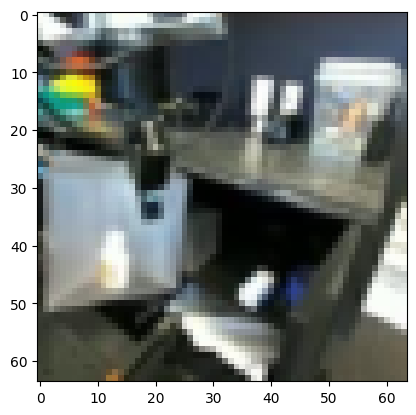

In [43]:
p.imshow(x[2].detach().cpu().numpy().transpose(1, 2, 0))

In [52]:
recon_img, _, _ = model(x[2].unsqueeze(0).to(DEVICE))
print(recon_img[0].shape)
img = recon_img[0].view(3, 64, 64).detach().cpu().numpy().transpose(1, 2, 0)

torch.Size([1, 12288])


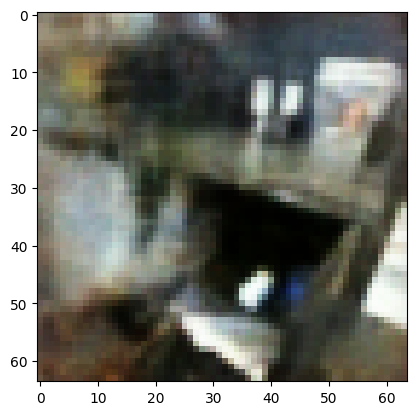

In [56]:
p.imshow(img)

## Test model

In [ ]:
# checkpoint = torch.load('/home/qwest/project/PycharmProjects/Reinforsment_Learning/test_W/VAE_checkpoint_1283.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
model.eval()

test on exist image 

In [ ]:
x = next(iter(train_loader))
print(x.size())
reconstructed, mu, _ = model(x.to(DEVICE))
reconstructed = reconstructed.view(-1, 3, 64, 64).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(reconstructed):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img))

transition of image to image

In [ ]:
first_dog_idx = 3
second_dog_idx = 8

dz = (mu[second_dog_idx] - mu[first_dog_idx]) / 31
walk = Variable(torch.randn(32, latent_dim, 4, 4)).to(DEVICE)
walk[0] = mu[first_dog_idx]

for i in range(1, 32):
    walk[i] = walk[i-1] + dz
walk = model.decoder(walk).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(walk):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img))

generate image from nose

In [ ]:
samples = Variable(torch.randn(32, latent_dim, 4, 4)).to(DEVICE)
samples = model.decoder(samples).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(samples):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img))

In [36]:
torch.save(model.state_dict(), "ROBOT.pt")

In [17]:
reconstructed, _, _ = model(x[0][None, :, :, :].to(DEVICE))

In [18]:
reconstructed = reconstructed.view(-1, 3, 64, 64).detach().cpu().numpy().transpose(0, 2, 3, 1)


In [ ]:
reconstructed[0].shape